In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stock = 'C6L.SI'
data = yf.download(stock, period='10y', interval='1d', multi_level_index= False)
assert isinstance(data, pd.DataFrame), "Data should be a pandas DataFrame"
data.head(3)
data.to_csv(stock + '.csv')

/var/folders/m2/ypp7y9612mg1zmlthw8d_j0c0000gp/T/ipykernel_98813/1460612641.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, period='10y', interval='1d', multi_level_index= False)
[*********************100%***********************]  1 of 1 completed


In [4]:
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
# RSI
def RSI(data, period=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=2).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=2).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
data['RSI'] = RSI(data, period=14)

# MACD
def MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal
data['MACD'], data['MACD_Signal'] = MACD(data)

# moving average
def moving_average(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

data['MA5'] = moving_average(data, window=5)
data['MA10'] = moving_average(data, window=10)
data['MA20'] = moving_average(data, window=20)
data['MA50'] = moving_average(data, window=50)
data['MA100'] = moving_average(data, window=100)
data['MA200'] = moving_average(data, window=200)

# Bollinger Bands
def bollinger_bands(data, window=14, num_std_dev=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
data['Upper_Band'], data['Lower_Band'] = bollinger_bands(data)

# Stochastic Oscillator
def stochastic_oscillator(data, k_window=14, d_window=3):
    low_min = data['Low'].rolling(window=k_window).min()
    high_max = data['High'].rolling(window=k_window).max()
    k = 100 * ((data['Close'] - low_min) / (high_max - low_min))
    d = k.rolling(window=d_window).mean()
    return k, d
data['%K'], data['%D'] = stochastic_oscillator(data)

# Average True Range (ATR)
def ATR(data, period=14):
    high_low = data['High'] - data['Low']
    high_close_prev = abs(data['High'] - data['Close'].shift(1))
    low_close_prev = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=2).mean()
    return atr
data['ATR'] = ATR(data)

# Commodity Channel Index (CCI)
def CCI(data, period=20):
    tp = (data['High'] + data['Low'] + data['Close']) / 3
    sma = tp.rolling(window=period, min_periods=1).mean()
    mad = abs(tp - sma).rolling(window=period, min_periods=1).mean()
    cci = (tp - sma) / (0.015 * mad)
    return cci
data['CCI'] = CCI(data)

# On-Balance Volume (OBV)
def OBV(data):
    obv = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()
    return obv
data['OBV'] = OBV(data)

# Rate of Change (ROC)
def ROC(data, period=12):
    roc = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100
    return roc
data['ROC'] = ROC(data)

# Williams %R
def williams_r(data, period=14):
    highest_high = data['High'].rolling(window=period).max()
    lowest_low = data['Low'].rolling(window=period).min()
    r = ((highest_high - data['Close']) / (highest_high - lowest_low)) * -100
    return r
data['Williams_R'] = williams_r(data)

# Accumulation/Distribution Line (A/D Line)
def AD_Line(data):
    money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    money_flow_volume = money_flow_multiplier * data['Volume']
    ad_line = money_flow_volume.cumsum()
    return ad_line
data['AD_Line'] = AD_Line(data)

# Money Flow Index (MFI)
def MFI(data, period=14):
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    money_flow = typical_price * data['Volume']
    positive_flow = money_flow.where(typical_price > typical_price.shift(1), 0).rolling(window=period).sum()
    negative_flow = money_flow.where(typical_price < typical_price.shift(1), 0).rolling(window=period).sum()
    money_flow_ratio = positive_flow / negative_flow
    mfi = 100 - (100 / (1 + money_flow_ratio))
    return mfi
data['MFI'] = MFI(data)

# Parabolic SAR (Stop and Reverse)
def parabolic_sar(data, acceleration=0.02, acceleration_max=0.2):
    sar = pd.Series(index=data.index)
    uptrend = True
    sar[0] = data['Low'][0] - ATR(data, period=14)[0]  # Initial SAR value (arbitrary)
    ep = data['High'][0]  # Initial extreme point (highest high in uptrend)
    accel = acceleration

    for i in range(1, len(data)):
        if uptrend:
            sar[i] = sar[i-1] + accel * (ep - sar[i-1])
            if data['Low'][i] < sar[i]:
                uptrend = False
                sar[i] = ep
                ep = data['Low'][i]
                accel = acceleration
            elif data['High'][i] > ep:
                ep = data['High'][i]
                accel = min(accel + acceleration, acceleration_max)
        else:  # Downtrend
            sar[i] = sar[i-1] + accel * (ep - sar[i-1])
            if data['High'][i] > sar[i]:
                uptrend = True
                sar[i] = ep
                ep = data['High'][i]
                accel = acceleration
            elif data['Low'][i] < ep:
                ep = data['Low'][i]
                accel = min(accel + acceleration, acceleration_max)
    return sar
# data['SAR'] = parabolic_sar(data)

# Average Directional Index (ADX)
def ADX(data, period=14):
    delta = data['Close'].diff()
    up = delta.where(delta > 0, 0)
    down = -delta.where(delta < 0, 0)

    tr = pd.concat([data['High'] - data['Low'], abs(data['High'] - data['Close'].shift(1)), abs(data['Low'] - data['Close'].shift(1))], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()

    plus_dm = up.rolling(window=period, min_periods=1).sum()
    minus_dm = down.rolling(window=period, min_periods=1).sum()

    plus_di = (plus_dm / atr) * 100
    minus_di = (minus_dm / atr) * 100

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period, min_periods=1).mean()

    return adx, plus_di, minus_di
# data['ADX'], data['+DI'], data['-DI'] = ADX(data)

# Ichimoku Cloud (Simplified - only Senkou Spans)
def ichimoku_cloud(data, tenkan_period=9, kijun_period=26, senkou_b_period=52):
    high_9 = data['High'].rolling(window=tenkan_period).max()
    low_9 = data['Low'].rolling(window=tenkan_period).min()
    tenkan_sen = (high_9 + low_9) / 2

    high_26 = data['High'].rolling(window=kijun_period).max()
    low_26 = data['Low'].rolling(window=kijun_period).min()
    kijun_sen = (high_26 + low_26) / 2

    senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(kijun_period)

    high_52 = data['High'].rolling(window=senkou_b_period).max()
    low_52 = data['Low'].rolling(window=senkou_b_period).min()
    senkou_span_b = ((high_52 + low_52) / 2).shift(kijun_period)

    return senkou_span_a, senkou_span_b
data['Senkou_A'], data['Senkou_B'] = ichimoku_cloud(data)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


class StockPricePredictor:
    """
    A class that defines and instantiates an RNN model (LSTM) for predicting stock prices.
    """

    def __init__(self, sequence_length, num_features=4, lstm_units=50, dropout_rate=0.2):
        """
        Initializes the StockPricePredictor class.

        Args:
            sequence_length (int): The number of time steps to use for each input sequence.
            num_features (int, optional): The number of features per time step (e.g., open, high, low, close). Defaults to 4.
            lstm_units (int, optional): The number of units in the LSTM layer. Defaults to 50.
            dropout_rate (float, optional): The dropout rate to apply. Defaults to 0.2.
        """
        self.sequence_length = sequence_length
        self.num_features = num_features
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds the RNN model (LSTM) using TensorFlow's Keras API.  This is a *private* method,
        indicated by the leading underscore.  It should only be called from within the class.

        Returns:
            tf.keras.Model: The compiled RNN model.
        """
        model = Sequential()
        # Add an LSTM layer with dropout
        model.add(
            LSTM(units=self.lstm_units, input_shape=(self.sequence_length, self.num_features), return_sequences=True)
        )  # Important to return sequences for stacking LSTM layers
        model.add(Dropout(self.dropout_rate))

        # Add a second LSTM layer with dropout
        model.add(LSTM(units=self.lstm_units, return_sequences=False))
        model.add(Dropout(self.dropout_rate))

        # Add a Dense layer for the output (predicting the next day's closing price)
        model.add(Dense(units=1))

        # Compile the model
        model.compile(optimizer=Adam(), loss="mean_squared_error")  # You can adjust the optimizer and loss
        return model

    def train(self, x_train, y_train, epochs=100, batch_size=32, validation_data=None, callbacks=None):
        """
        Trains the RNN model.

        Args:
            x_train (numpy.ndarray): The training input data.
            y_train (numpy.ndarray): The training output data.
            epochs (int, optional): The number of epochs to train for. Defaults to 100.
            batch_size (int, optional): The batch size to use. Defaults to 32.
            validation_data (tuple, optional): Validation data (x_val, y_val) for monitoring performance. Defaults to None.
            callbacks (list, optional): List of Keras callbacks to apply during training. Defaults to None.

        Returns:
            tf.keras.callbacks.History: The training history object.
        """
        print("x_train shape:", x_train.shape)
        print("y_train shape:", y_train.shape)

        return self.model.fit(
            x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=callbacks
        )

    def predict(self, x_test):
        """
        Makes predictions using the trained RNN model.

        Args:
            x_test (numpy.ndarray): The test input data.

        Returns:
            numpy.ndarray: The predicted stock prices.
        """
        print("x_test shape:", x_test.shape)
        predictions = self.model.predict(x_test)
        return predictions

    def evaluate(self, x_test, y_test) -> float:
        """
        Evaluates the trained RNN model.

        Args:
            x_test (numpy.ndarray): The test input data.
            y_test (numpy.ndarray): The test output data.

        Returns:
            float: The loss value on the test data.
        """
        return self.model.evaluate(x_test, y_test)

    def get_model(self):
        """
        Returns the underlying Keras model.  This can be useful for saving, loading,
        or further manipulation.

        Returns:
            tf.keras.Model: The Keras model.
        """
        return self.model

    def save_model(self, filepath: str) -> None:
        """
        Saves the trained model to a file.

        Args:
            filepath (str): The path to save the model to.
        """
        self.model.save(filepath)

    def load_model(self, filepath: str) -> None:
        """
        Loads a trained model from a file.

        Args:
            filepath (str): The path to load the model from.
        """
        self.model = tf.keras.models.load_model(filepath)

    @classmethod
    def prepare_data(
        cls,
        data,
        sequence_length,
        prediction_horizon_length=1,
        features=["Open", "High", "Low", "Close"],
        target_feature="Close",
    ):
        """
        Prepares the data for training and testing the RNN model.  This is a *static* method,
        so it is called on the class itself (StockPricePredictor.prepare_data()) rather than
        on an instance of the class (my_predictor = StockPricePredictor(); my_predictor.prepare_data()).
        Static methods don't have access to `self`.

        Args:
            data (pandas.DataFrame): The input data, assumed to be a pandas DataFrame with
                columns including 'Open', 'High', 'Low', and 'Close'.
            sequence_length (int): The number of time steps to use for each input sequence.
            features (list, optional):  List of features to use from the DataFrame.
                Defaults to ['Open', 'High', 'Low', 'Close'].
            target_feature (str, optional): The feature to predict. Defaults to 'Close'.

        Returns:
            tuple: A tuple containing (x_data, y_data), where x_data is the input data
                   shaped as (number_of_sequences, sequence_length, number_of_features),
                   and y_data is the target data shaped as (number_of_sequences,).
                   Returns None if the input data has insufficient length.
        """
        if len(data) < sequence_length + prediction_horizon_length:
            print(
                f"Data length ({len(data)}) is less than sequence length + 1 ({sequence_length + prediction_horizon_length}).  Returning None."
            )
            return None, None

        data_values = data[features].values
        target_values = data[target_feature].values

        x_data = []
        y_data = []

        for i in range(len(data_values) - sequence_length):
            x_data.append(data_values[i : i + sequence_length])
            y_data.append(target_values[i + sequence_length: i + sequence_length + prediction_horizon_length])

        x_data = np.array(x_data)
        y_data = np.array(y_data)

        return x_data, y_data


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Choose the sequence length
sequence_length = 30  # Use the past 30 days of data to predict the next day

# Prepare the data using the static method
x, y = StockPricePredictor.prepare_data(data, sequence_length, 1)

if x is not None and y is not None:
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, shuffle=False)

    # Scale the data (important for neural networks)
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    predictor = StockPricePredictor(
        sequence_length=sequence_length, num_features=x_train.shape[2]
    )  # num_features is inferred from the data

    history = predictor.train(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

    predictions = predictor.predict(x_test)

    # predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    # y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    loss = predictor.evaluate(x_test, y_test)
    print(f"Test Loss: {loss}")
    predictor.save_model("RNN_model.keras")
else:
    print("Data preparation failed.  Check your input data and sequence length.")

x_train shape: (528, 30, 4)
y_train shape: (528, 1, 1)
Epoch 1/100


/Users/ngtzekean/personal/Stock-price-prediction-fuzzy-RNN/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0559 - val_loss: 0.0068
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0098
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 5.5139e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2352e-04 - val_loss: 8.7836e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1421e-04 - val_loss: 5.5839e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2967e-04 - val_loss: 5.0036e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7265e-04 - val_loss: 6.5330e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.6675e-04 - val_loss: 9.6298e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.4846e-04 - val_loss: 5.0209e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5348e-04 - val_loss: 4.8927e-04
Epoch 12/100
1

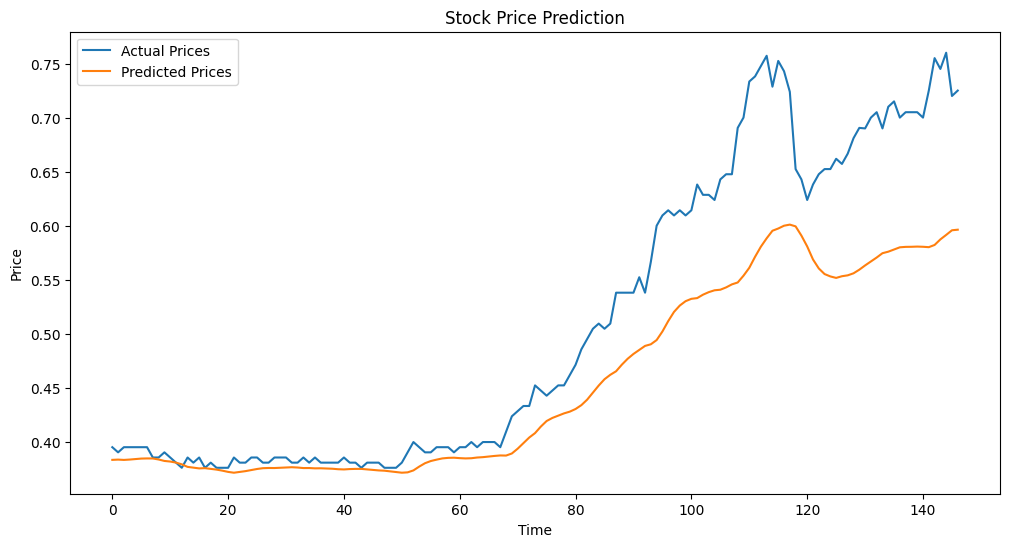

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.reshape(-1, 1), label="Actual Prices")
plt.plot(predictions, label="Predicted Prices")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [8]:
loaded_predictor = StockPricePredictor(
    sequence_length=sequence_length, num_features=x_train.shape[2]
)
loaded_predictor.load_model("RNN_model.keras")
loaded_predictions = loaded_predictor.predict(x_test)

x_test shape: (147, 30, 4)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
